In [1]:
train_path = 'data/car_brand_logos/Train/'
test_path = 'data/car_brand_logos/Test/'

In [2]:
SAVE_PATH = 'trained/deep_copy/aug_25_best.pth'

using_res = False

### Imports

In [3]:
import torch, torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize, Compose
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image
from PIL.features import pilinfo

from copy import deepcopy


import traceback
import warnings
warnings.filterwarnings("error")

### Useful functions to retrive the data

In [4]:
# create a annotations_file.csv (index -> img (name), label (int))

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [5]:
# create the pool of images (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # cnt = 0
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
            # cnt += 1
        # print(f"Label: {d} - Number: {cnt}")
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

#### old version

In [6]:
if not using_res:
    # wrong_images_path = []
    # import traceback

    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = read_image(self.images.loc[idx][0])
            except Exception:
                print('Found error at {} {}'.format(self.images.loc[idx][0], idx))
            #     wrong_images_path.append(self.images.loc[img_name][0])
                #return torch.zeros((1, 600, 600)), -1
            # image = read_image(self.images.loc[img_name][0])
            if image.shape[0] >= 3: #apply grayscale to colored img
                image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
            else: #we have a greyscaled image, move it into tensor 
                image = to_tensor(ToPILImage()(image))

            image = Resize((300, 300))(image)
            #data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0]
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20
                    #print (f'Rotate: {angle}')
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0]
                if fr == 1: 
                    image = hflip(image)

            #image = image.permute(1,2,0) #made to be shown on matplotlib
            label = self.img_labels.loc[idx][1]
            #if self.transform:
            #    image = self.transform(image)
            #if self.target_transform:
            #    label = self.target_transform(label)

            return image, label

#### new version (resnet)

In [7]:
if using_res:
    wrong_images_path = []

    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
                # exif_data = image._getexif()
                if Image.MIME[image.format] == 'image/png': #wrong format, we want only jpg
                        image = convertPNGImage(self.images.loc[idx][0], 'PNG')
            # except UserWarning:
            #     print('Found exif error at {} in position {}'.format(self.images.loc[idx][0], idx))
            #     wrong_images_path.append('EXIF '+self.images.loc[idx][0])
            except Exception:
                print('Found exif error at {} in position {}'.format(self.images.loc[idx][0], idx))
                # wrong_images_path.append(self.images.loc[idx][0])
                
            image = ToTensor()(image)
            
            if image.shape[0] != 3: #color grayscaled and convert RGBA
                image = ToPILImage()(image).convert('RGB')
                
            else: #rgb, don't touch it 
                image = ToPILImage()(image)
                
            preprocess = Compose([
                Resize(300),
                CenterCrop(300),
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = preprocess(image)
            
            
            #  COMMENT ME
            # print(f"idx: {idx} - path: {self.images.loc[idx][0]}")
            
            
            
            #data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0]
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20
                    #print (f'Rotate: {angle}')
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0]
                if fr == 1: 
                    image = hflip(image)

            label = self.img_labels.loc[idx][1]

            return image, label

### Creating the 2 dataset and testing

In [8]:
# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), target_transform=ToTensor())

test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'train dataset: {train_data.__len__()}')
print (f'test dataset: {test_data.__len__()}')

train dataset: 2512
test dataset: 400


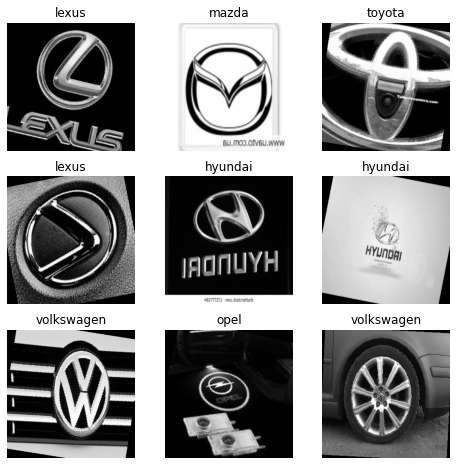

In [9]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    # print (img.shape, img.dtype, label)
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    if not using_res:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([8, 1, 300, 300])
Labels batch shape: torch.Size([8])


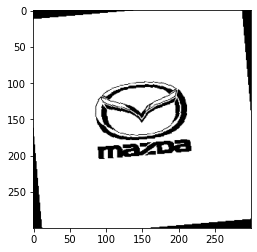

Label: mazda


In [10]:
train_dl = DataLoader(train_data, batch_size=8, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0] #picking the first img and label of the batch
label = labels[0]
if not using_res:
    plt.imshow(img.squeeze(), cmap='gray')
else:
    plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()
print(f"Label: {diz[label.item()]}")

In [11]:
labels

tensor([2, 6, 2, 7, 4, 1, 3, 6])

### Defining the neural network

In [12]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [14]:
if not using_res:
    class Net(nn.Module):

        def __init__(self):
            super(Net, self).__init__()

            #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
            self.conv1 = nn.Conv2d(1, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)        
            self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
            self.fc_layer2 = nn.Linear(120, 84)
            self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

        def forward(self, x):
            # Max pooling over a (2, 2) window
            x = self.pool(F.relu(self.conv1(x)))
            #print ('conv1', x.shape)
            # If the size is a square, you can specify with a single number
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
            #print ('flatten', x.shape)
            x = F.relu(self.fc_layer1(x))
            x = F.relu(self.fc_layer2(x))
            x = self.fc_layer3(x)
            return x

### Testing the network on test set

In [15]:
if not using_res:
    loaded = Net()
else:
    loaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

In [16]:
loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.to(device)
loaded.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_layer1): Linear(in_features=82944, out_features=120, bias=True)
  (fc_layer2): Linear(in_features=120, out_features=84, bias=True)
  (fc_layer3): Linear(in_features=84, out_features=8, bias=True)
)

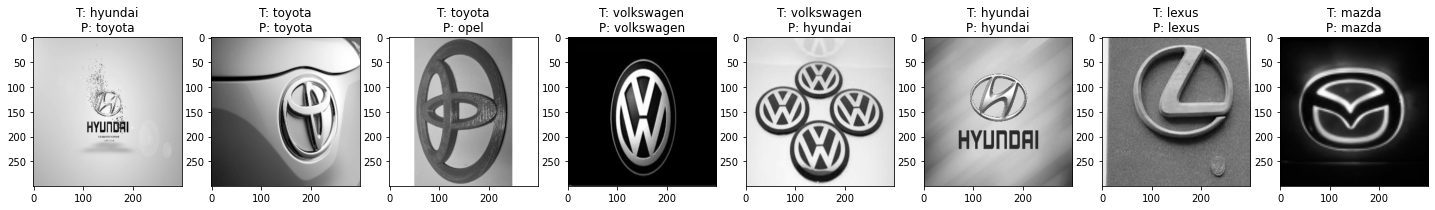

In [17]:
images, labels = next(iter(test_dl)) #picking a batch

n_imgs = len(images)
img = images.to(device)
label = labels.to(device)

preds = loaded(img)
_, best_pred = torch.max(preds.data, 1)

fig, axs = plt.subplots(figsize=(25,4), nrows=1, ncols=n_imgs)

for i in range(n_imgs):
    axs[i].imshow(img[i].permute(1,2,0).cpu(), cmap='gray')
    axs[i].set_title('T: {}\nP: {}'.format(diz[label[i].item()], diz[best_pred[i].item()]))

In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in diz}
total_pred = {classname: 0 for classname in diz}

y_true = []
y_pred = []

# again no gradients needed
# with torch.no_grad():
for data in test_dl:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = loaded(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[label.item()] += 1
        total_pred[label.item()] += 1
        y_true.append(label.cpu())
        y_pred.append(prediction.cpu())

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {diz[classname]} is {accuracy:.1f} %')

Accuracy for class: hyundai is 56.0 %
Accuracy for class: lexus is 56.0 %
Accuracy for class: mazda is 82.0 %
Accuracy for class: mercedes is 62.0 %
Accuracy for class: opel is 60.0 %
Accuracy for class: skoda is 42.0 %
Accuracy for class: toyota is 54.0 %
Accuracy for class: volkswagen is 68.0 %


In [19]:
#stampa report classificazioni
print(classification_report(y_true, y_pred, target_names=diz.values()))

              precision    recall  f1-score   support

     hyundai       0.61      0.56      0.58        50
       lexus       0.42      0.56      0.48        50
       mazda       0.62      0.82      0.71        50
    mercedes       0.69      0.62      0.65        50
        opel       0.60      0.60      0.60        50
       skoda       0.70      0.42      0.53        50
      toyota       0.60      0.54      0.57        50
  volkswagen       0.67      0.68      0.67        50

    accuracy                           0.60       400
   macro avg       0.61      0.60      0.60       400
weighted avg       0.61      0.60      0.60       400



In [20]:
# loss function
criterion = nn.CrossEntropyLoss()

In [21]:
with torch.no_grad():
    test_loss = 0
    test_batch = 0
    for _, data in enumerate(test_dl):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        #inputs = inputs.permute(0, 3, 1, 2)
        outputs = loaded(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_batch += 1
    actual_test_loss = test_loss/test_batch
    print(f"test loss: {(actual_test_loss):.3f}")

test loss: 1.494


### Confusion matrix

In [22]:
def createConfusionMatrix(loader, netw):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = netw(inputs.to(device))  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = diz.values()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    #normalization
    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    df_cm = pd.DataFrame(cmn, index=[i for i in classes],
                         columns=[i for i in classes])
    sn.heatmap(df_cm, annot=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    im = Image.open(buf)
    im = ToTensor()(im)
    return im

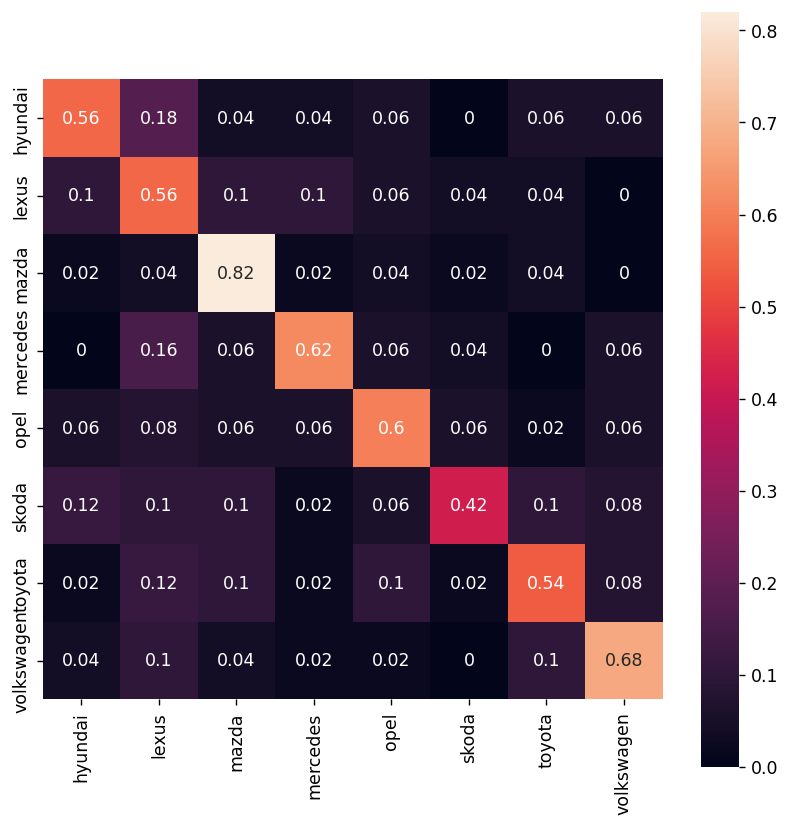

In [23]:
# %%time

plt.figure(figsize=(8, 8), dpi=125)
plt.imshow(createConfusionMatrix(test_dl, loaded).permute(1,2,0))